In [79]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import numpy as np
import matplotlib.pyplot as plt

#### English stopwords

In [80]:
stopwords = nltk.corpus.stopwords.words('english')

In [81]:
messages = pd.read_csv('SMS.csv', encoding='utf8')
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [82]:
messages.text[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [83]:
messages.info()
messages.shape
messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5574 non-null   object
 1   text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,text
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [84]:
messages.label.value_counts()

ham     4827
spam     747
Name: label, dtype: int64

#### Imbalance ratio check

In [85]:
h = messages.label.value_counts()[0]
s = messages.label.value_counts()[1]
print(f'The spam\ham imbalance ratio is: {round(s/(s+h),2)} to {round(h/(s+h),2)}')

The spam\ham imbalance ratio is: 0.13 to 0.87


#### We may want to correct it using resampling methods

In [86]:
def clean_text(text):
    """ This function removes punctuation marks and cleans the text from 'stopwords'.
    The output of the function is a clean list of words of the text."""
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

In [87]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(messages['text'])
# we took only the 'text' part (features)

In [88]:
X_tfidf

<5574x9446 sparse matrix of type '<class 'numpy.float64'>'
	with 50460 stored elements in Compressed Sparse Row format>

In [89]:
# coverting the sparse matrix into a dtatframe
X_features = pd.DataFrame(X_tfidf.toarray())

In [90]:
X_features.head()

,0,1,2,3,4,5,6,7,8,9,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Building different models

In [91]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [92]:
# Two options: 
#(1)sparse matrix (2)DataFrame
X1 = X_tfidf 
X = X_features
y = messages['label']

In [99]:
def model_score(X,y,model):
    global M
    if model == 'lgr':
        model = LogisticRegression()
    elif model == 'rf':
        model = RandomForestClassifier()
    elif model == 'gb': 
        model = GradientBoostingClassifier()
    elif model == 'gnb':
        model = GaussianNB()
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='ham')
    recall = recall_score(y_test, y_pred, pos_label='ham')
    print("The precision is:   %.3f" % precision)
    print("The recall is:      %.3f" % recall)
    print("Accuracy test:      %.3f" % model.score(X_test,y_test))
    print("Accuracy train:     %.3f" % model.score(X_train,y_train))
    M = model
    return M

In [94]:
%%time
model_score(X,y,'lgr')
# Using X  = 3.8s
# Using X1 = 0.25s

The precision is:   0.952
The recall is:      0.995
Accuracy test:      0.952
Accuracy train:     0.969
Wall time: 323 ms


LogisticRegression()

In [95]:
%%time
model_score(X,y,'rf')
# Using X  = 26s
# Using X1 = 11.6s

The precision is:   0.972
The recall is:      1.000
Accuracy test:      0.976
Accuracy train:     1.000
Wall time: 11.5 s


RandomForestClassifier()

In [96]:
%%time
model_score(X,y,'gb')
# Using X  = ~minutes
# Using X1 = 11.3s

The precision is:   0.963
The recall is:      0.998
Accuracy test:      0.965
Accuracy train:     0.976
Wall time: 11.4 s


GradientBoostingClassifier()

In [98]:
%%time
model_score(X,y,'gnb')
# Using X  = 7.1s
# Using X1 = didn't work

The precision is:   0.982
The recall is:      0.882
Accuracy test:      0.885
Accuracy train:     0.951
Wall time: 7.5 s


GaussianNB()

### Imbalance correction - applying RandomOverSampling method

In [100]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [103]:
# sanity check (did the resampling worked? yes)
(y_ros == 'ham').mean()

0.5

In [104]:
model = LogisticRegression()

In [105]:
%%time
model.fit(X_ros, y_ros)
# 0.13s

Wall time: 5.53 s


LogisticRegression()

In [106]:
model.score(X_test,y_test)

0.9775784753363229

In [107]:
model.score(X_ros, y_ros)

0.9952233410792667

In [112]:
model = RandomForestClassifier()

In [113]:
%%time
model.fit(X_ros, y_ros)
# 11.7s

Wall time: 34.2 s


RandomForestClassifier()

In [114]:
model.score(X_test,y_test)

0.9820627802690582

In [115]:
model.score(X_ros, y_ros)

1.0

In [116]:
model = GradientBoostingClassifier()

In [117]:
%%time
model.fit(X_ros, y_ros)
# 10.9s

Wall time: 3min 15s


GradientBoostingClassifier()

In [118]:
model.score(X_test,y_test)

0.95695067264574

In [119]:
model.score(X_ros, y_ros)

0.93712884069197

In [120]:
model = GaussianNB()

In [121]:
%%time
model.fit(X_ros, y_ros)
# 5.21s

Wall time: 5.19 s


GaussianNB()

In [122]:
model.score(X_test,y_test)

0.885201793721973

In [123]:
model.score(X_ros, y_ros)

0.971727343144849

In [49]:
# Logistic regression and Random forest have improved
# GaussianNB hasn't changed and GB got worse

### Basic RNN model

In [124]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### Data Prep

In [125]:
messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [126]:
Xr = messages['clean_text']
yr = messages['label']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

#### Converting the items of clean_text from list to str (for the tokenzing part)

In [128]:
X_train = pd.Series([f'{X_train.values[i]}' for i in range(X_train.shape[0])])
X_test = pd.Series([f'{X_test.values[i]}' for i in range(X_test.shape[0])])

#### Train the tokenizer and use it to convert the sentences to sequence of numbers

In [129]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

We can take a look at the vocabulary

In [130]:
tfidf_vect.vocabulary_

{'go': 3800,
 'jurong': 4693,
 'point': 6441,
 'crazy': 2507,
 'available': 1425,
 'bugis': 1893,
 'n': 5683,
 'great': 3897,
 'world': 9190,
 'la': 4855,
 'e': 3032,
 'buffet': 1891,
 'cine': 2225,
 'got': 3857,
 'amore': 1192,
 'wat': 8955,
 'ok': 6002,
 'lar': 4894,
 'joking': 4661,
 'wif': 9085,
 'u': 8615,
 'oni': 6034,
 'free': 3585,
 'entry': 3168,
 '2': 438,
 'wkly': 9142,
 'comp': 2341,
 'win': 9099,
 'fa': 3305,
 'cup': 2563,
 'final': 3430,
 'tkts': 8387,
 '21st': 458,
 'may': 5342,
 '2005': 445,
 'text': 8225,
 '87121': 885,
 'receive': 6842,
 'questionstd': 6733,
 'txt': 8599,
 'ratetcs': 6786,
 'apply': 1278,
 '08452810075over18s': 73,
 'dun': 3018,
 'say': 7201,
 'early': 3039,
 'hor': 4230,
 'c': 1940,
 'already': 1165,
 'nah': 5690,
 'dont': 2925,
 'think': 8298,
 'goes': 3814,
 'usf': 8749,
 'lives': 5058,
 'around': 1329,
 'though': 8317,
 'freemsg': 3593,
 'hey': 4126,
 'darling': 2627,
 '3': 550,
 'weeks': 9009,
 'word': 9176,
 'back': 1476,
 'id': 4351,
 'like': 5

Pad the sequences so each sequence is the same length 50, which can be tuned

In [131]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [132]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential

#### Creating recall and precision functions

In [133]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [134]:
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [135]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          266112    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 275,521
Trainable params: 275,521
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [137]:
y_train = y_train.replace('spam', 1)
y_train = y_train.replace('ham', 0)
y_test = y_test.replace('spam', 1)
y_test = y_test.replace('ham', 0)

In [138]:
%%time
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Train on 4459 samples, validate on 1115 samples
Epoch 1/10
4459/4459 [==============================] - 7s 2ms/step - loss: 0.2697 - accuracy: 0.9110 - precision_m: 0.5269 - recall_m: 0.4112 - val_loss: 0.0686 - val_accuracy: 0.9821 - val_precision_m: 0.9943 - val_recall_m: 0.8739
Epoch 2/10
4459/4459 [==============================] - 7s 1ms/step - loss: 0.0330 - accuracy: 0.9906 - precision_m: 0.9506 - recall_m: 0.9196 - val_loss: 0.0476 - val_accuracy: 0.9874 - val_precision_m: 0.9952 - val_recall_m: 0.9318
Epoch 3/10
4459/4459 [==============================] - 6s 1ms/step - loss: 0.0080 - accuracy: 0.9980 - precision_m: 0.9976 - recall_m: 0.9866 - val_loss: 0.0578 - val_accuracy: 0.9883 - val_precision_m: 0.9952 - val_recall_m: 0.9347
Epoch 4/10
4459/4459 [==============================] - 6s 1ms/step - loss: 0.0034 - accuracy: 0.9991 - precision_m: 0.9857 - recall_m: 0.9763 - val_loss: 0.0544 - val_accuracy: 0.9892 - val_precision_m: 0.9881 - val_recall_m: 0.9488
Epoch 5/10
4459/

#### Calculation time for basic RNN model ~70s

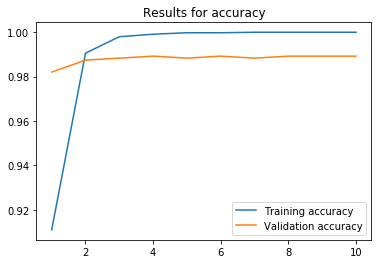

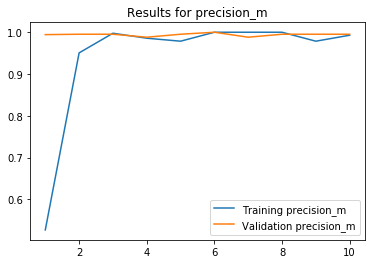

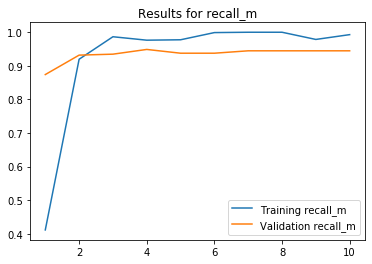

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history[f'val_{i}']
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label=f'Training {i}')
    plt.plot(epochs, val_acc, label=f'Validation {i}')
    plt.title(f'Results for {i}')
    plt.legend()
    plt.show()

#### After 4 epochs the validation measures are stabilized

In [140]:
val_acc_5 = history.history['val_accuracy'][3]
val_pre_5 = history.history['val_precision_m'][3]
val_rec_5 = history.history['val_recall_m'][3]

In [141]:
print("Validation accuracy after 5 epochs:   %.3f" % val_acc_5)
print("Validation precision after 5 epochs:  %.3f" % val_pre_5)
print("Validation recall after 5 epochs:     %.3f" % val_rec_5)

Validation accuracy after 5 epochs:   0.989
Validation precision after 5 epochs:  0.988
Validation recall after 5 epochs:     0.949


### Dimensionality reduction - applying PCA method

Returning to our original features 

In [142]:
Xt = X_features
yt = messages['label']

In [143]:
Xt.head()

,0,1,2,3,4,5,6,7,8,9,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

In [145]:
from sklearn.decomposition import PCA

In [146]:
# Since the number of features (columns) is greater than the number of records (rows)
# Thus, we had to apply the method on the 'rows' (we might loose some information)

In [147]:
N = X_train.shape[0]
pca = PCA(n_components=N)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([9.52985709e-03, 8.08605013e-03, 6.99556787e-03, ...,
       2.30873569e-37, 7.57046645e-38, 1.97713871e-39])

In [148]:
model = RandomForestClassifier()

In [149]:
model.fit(X_train_pca, y_train)

RandomForestClassifier()

In [150]:
model.score(X_test_pca, y_test)

0.895067264573991

In [151]:
model.score(X_train_pca, y_train)

1.0

For all components there is a big over-fit; test score = 0.895, train score = 1

#### Transverse scan locating the max train and test scores 

In [115]:
test = []
train = []
model = RandomForestClassifier(max_depth=7)
for i in [1,10,50,150,500,1000,3000]:
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)
    s1 = model.score(X_train_pca, y_train)
    train.append(s1)
    s2 = model.score(X_test_pca, y_test)
    test.append(s2)
    print(f'{i} comp - train score: {round(s1,3)}, test score: {round(s2,3)}')

1 comp - train score: 0.902, test score: 0.884
10 comp - train score: 0.977, test score: 0.968
50 comp - train score: 0.977, test score: 0.963
150 comp - train score: 0.971, test score: 0.961
500 comp - train score: 0.961, test score: 0.941
1000 comp - train score: 0.951, test score: 0.917
3000 comp - train score: 0.895, test score: 0.865


(-0.5, 12)

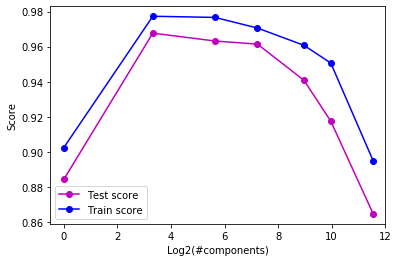

In [139]:
from matplotlib.legend_handler import HandlerLine2D

x = np.log2(np.array([1,10,50,150,500,1000,3000]))
line1, = plt.plot(x, test, color='m' ,marker='o', label='Test score')
line2, = plt.plot(x, train, color='b', marker='o', label='Train score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=1)})
plt.xlabel('Log2(#components)') 
plt.ylabel('Score') 
plt.xlim([-0.5,12])

It's clear from the plot that around the 10 components the both train and test score reach maximum  

#### Delicate scan finding the trend and the best scores (between 3-60 components) 

In [37]:
train = []
test = []
n_comp = []
model = RandomForestClassifier(max_depth=7, random_state=42)
for i in range(3,63,3):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)
    pred_train = model.predict(X_train_pca)
    pred_test = model.predict(X_test_pca)
    acc_train = accuracy_score(y_train, pred_train)
    pre_train = precision_score(y_train, pred_train, pos_label='ham')
    rec_train = recall_score(y_train, pred_train, pos_label='ham')
    acc_test = accuracy_score(y_test, pred_test)
    pre_test = precision_score(y_test, pred_test, pos_label='ham')
    rec_test = recall_score(y_test, pred_test, pos_label='ham')
    train.append([acc_train,pre_train,rec_train])
    test.append([acc_test,pre_test,rec_test])
    n_comp.append(i)

In [64]:
df_train = pd.DataFrame(train, columns=['acc_train','pre_train','rec_train'])
df_test = pd.DataFrame(test, columns=['acc_test','pre_test','rec_test'])
n_comp = pd.Series(n_comp, name='n_comp')
df_tot = pd.concat([n_comp, df_train, df_test], axis=1)

In [66]:
df_tot.head()

,n_comp,acc_train,pre_train,rec_train,acc_test,pre_test,rec_test
0,3,0.932720,0.934143,0.992512,0.938117,0.935961,0.995807
1,6,0.966809,0.972117,0.990188,0.956054,0.966976,0.982180
2,9,0.975555,0.977423,0.994836,0.965022,0.972136,0.987421
3,12,0.976228,0.976956,0.996127,0.966816,0.970256,0.991614
4,15,0.977349,0.976263,0.998193,0.967713,0.969325,0.993711


In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

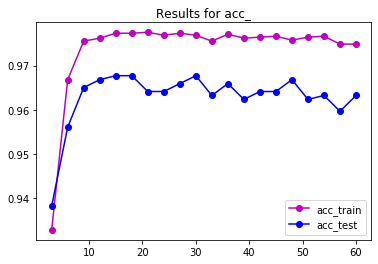

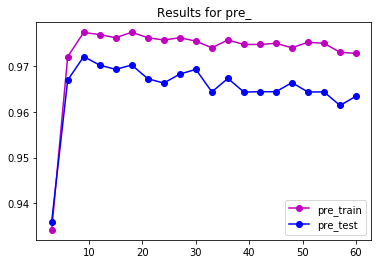

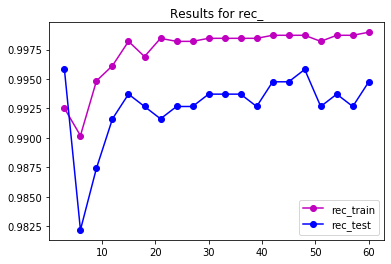

In [78]:
for i in ['acc_', 'pre_', 'rec_']:

    plt.figure()
    plt.plot(df_tot.n_comp, df_tot[f'{i}train'], color='m' ,marker='o', label=f'{i}train')
    plt.plot(df_tot.n_comp, df_tot[f'{i}test'], color='b', marker='o', label=f'{i}test')
    plt.title(f'Results for {i}')
    plt.legend()
    plt.show()

#### Observations
* It can be seen that the scores are stablizied approximately around 15 components
* The test scores are as follows: accuracy = 0.968, precision = 0.969, recall = 0.994

## Summary

* The project started by cleaning the text, removing stopwords and punctuation
* The clean messages were vectorized using TfidfVectorizer
* Basic models were built and tested on the dataset
* An imbalance problem was obsereved and corrected by resampling the data
* RNN sequential was built including data preparation
* The results were measured in terms of accuracy, precision and recall
* Dimensionality reduction was applied

### Conclusions

* The highest scores were achieved for Random forest model with: acc = 0.976, pre = 0.972, rec = 1
* The results got improved a bit using the resampling method, but computation time was increased
* The fastest model was Logistic regression with very good results: acc = 0.95, pre = 0.95, rec = 0.995
* Using PCA method to reduce dimensionality we got very nice results and less overfitting problem
#### To conclude, the most accurate model was Random forest, and the fastest was Logistic regression